# 5. 합성곱 신경망Ⅰ
## 5.1 합성곱 신경망(Convolutional Neural Network, CNN, ConvNet)
* 합성곱 신경망은 이미지 전체를 한 번에 계산하는 것이 아닌 이미지의 국소적 부분을 계산해 시간과 자원을 절약해 이미지의 세밀한 부분까지 분석 가능
* 입력층, 합성곱층, 풀링층, 완전연결층, 출력층 순서로 이루어짐

#### 입력층(input layer)
* 입력 이미지 데이터가 최초로 거치게 되는 계층
* 이미지는 높이(height), 너비(width), 채널(channel)의 값을 갖는 3차원 데이터
* 컬러 이미지의 경우 채널은 3(RGB), 그레이스케일의 경우 채널은 1



#### 합성곱층(Convolutional layer)
* 입력 데이터에서 특성을 추출하는 역할을 수행하는 계층
* 이미지에 대한 특성을 감지하기 위해 커널(kernel)이나 필터를 사용
* 이미지의 모든 영역을 훑으면서 특성을 추출하는데 결과는 특성 맵(feature map)
* RGB의 경우 각 채널에 서로 다른 가중치로 합성곱을 진행해 결과를 더해줌
* 필터가 여러 개의 경우 각 필터에 맞춰 합성곱을 진행

#### 풀링층(Pooling layer)
* 합성곱층과 유사하게 특성 맵의 차원을 다운 샘플링하여 연산량을 감소시키고, 주요한 특성 벡터를 추출하여 학습을 효과적으로 진행
* 최대 풀링(max pooling): 대상 영역에서 최댓값을 추출
* 평균 풀링(average pooling): 대상 영역에서 평균을 반환

#### 완전연결층(Fully connected layer)
* 합성곱층과 풀링층을 거치면서 차원이 축소된 특성 맵은 최종적으로 완전연결층으로 전달
* 이미지는 3차원 벡터에서 1차원 벡터로 펼쳐짐

#### 출력층(Output layer)
* 예를 들어 이미지를 분류하는 문제에서는 출력층에 softmax activate function를 사용해 이미지가 각 레이블에 속할 확률 값을 출력


## 5.2 합성곱 신경망 맛보기
* 아래 예제는 fashion_mnist dataset을 사용할 예정
* 기본 MNIST 데이터셋처럼 열 가지로 분류될 수 있는 28x28 픽셀의 이미지 7만 개로 구성되어 있음
* 0에서 9까지 정수 같은 이미지(운동화, 셔츠 등)의 클래스를 나타내는 레이블
    0. T-shirt
    1. Trouser
    2. Pullover
    3. Dress
    4. Coat
    5. Sandal
    6. Shirt
    7. Sneaker
    8. Bag
    9. Ankle Boot

In [7]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # GPU 사용하기 위해 작성
print(device) 

cuda:0


#### 일반적으로 하나의 GPU를 사용할 때
``` python
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net()
model.to(device)
```
#### 다수의 GPU를 사용할 때
``` python
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net()
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(net)
model.to(device)
```
nn.DataParallel을 사용할 경우 배치 크기가 알아서 각 GPU로 분배되는 방식<br>
따라서 GPU 수만큼 배치 크기도 늘려줘야 한다.

In [14]:
train_dataset  = torchvision.datasets.FashionMNIST("../chap05/data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_dataset  = torchvision.datasets.FashionMNIST("../chap05/data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()])) 
# train, test dataset download
# 첫 번째 파라미터: 데이터를 다운받을 주소
# download: True시 다운받을 주소에 다운로드
# transform: 이미지를 텐서로 변경

0it [00:00, ?it/s]

Extracting ../chap05/data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../chap05/data\FashionMNIST\raw


0it [00:00, ?it/s]

Extracting ../chap05/data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../chap05/data\FashionMNIST\raw


0it [00:00, ?it/s]

Extracting ../chap05/data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../chap05/data\FashionMNIST\raw


0it [00:00, ?it/s]

Extracting ../chap05/data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../chap05/data\FashionMNIST\raw
Processing...
Done!


In [15]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=100)
# 다운로드받은 데이터를 메모리로 불러오기 위해 DataLoader 사용
# batch_size 만큼 데이터를 배치로 묶는다.

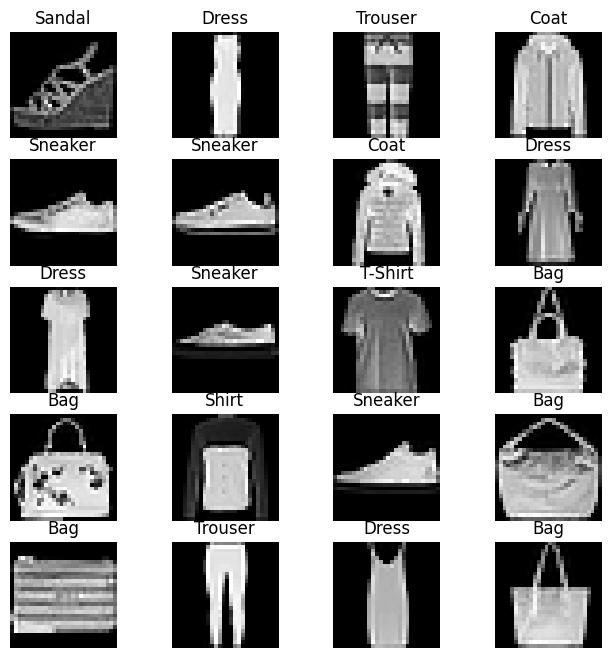

In [20]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

fig = plt.figure(figsize=(8,8)); # 출력할 이미지의 가로세로 길이로 단위는 inch
columns = 4;
rows = 5;
for i in range(1, columns*rows +1): # 20장 출력
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [88]:
import numpy as np

print(np.random.randint(10)) # 0 ~ 9 사이의 정수 하나 랜덤하게 추출
print(np.random.randint(1, 10)) # 1 ~ 9 사이의 정수 하나 랜덤하게 추출
print(np.random.rand(8), end = '\n\n') # 0 ~ 1 사이의 정규표준분포 난수를 행렬(1 x 8)로 표현
print(np.random.rand(4, 2), end = '\n\n') # 0 ~ 1 사이의 정규표준분포 난수를 행렬(4 x 2)로 표현
print(np.random.randn(8), end = '\n\n') # 평균이 0이고 표준편차가 1인 가우시안 정규분포 난수를 표현
print(np.random.randn(4, 2), end = '\n\n') # 평균이 0이고 표준편차가 1인 가우시안 정규분포 난수를 표현

0
6
3
[0.31312966 0.6155271  0.57044374 0.76676257 0.78072825 0.51425842
 0.49909136 0.56447091]

[[0.92966889 0.2238793 ]
 [0.20219045 0.00634415]
 [0.79555633 0.82103119]
 [0.19145551 0.57623903]]

[-0.74944281  0.7030532   0.28885959 -0.53480008 -1.10437771  0.8932362
  0.53113982 -0.9572707 ]

[[ 0.61334347  1.12622491]
 [ 0.30370542  0.4576411 ]
 [ 0.3587887   0.86464405]
 [-0.00266375 -1.31769872]]



In [90]:
class FashionDNN(nn.Module): # ConvNet이 적용되지 않은 network
    # class 형태의 모델은 nn.Module을 상속받음
    def __init__(self): # 객체가 갖는 속성 값을 초기화하는 역할
        super(FashionDNN,self).__init__() # FashionDNN이라는 부모 클래스를 상속
        self.fc1 = nn.Linear(in_features=784,out_features=256)
        self.drop = nn.Dropout2d(0.25)
        # 0.25만큼 비율로 텐서의 값이 0이 되고 아닌 부분은 1/(1-0.25)만틈 곱해 커진다.
        self.fc2 = nn.Linear(in_features=256,out_features=128)
        self.fc3 = nn.Linear(in_features=128,out_features=10)

    def forward(self,input_data):
        out = input_data.view(-1, 784)
        out = F.relu(self.fc1(out)) # F.relu는 forward() 함수에서 정의
        # nn.ReLU()는 __init__() 함수에서 정의
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [93]:
import torch
import torch.nn as nn

inputs = torch.randn(64, 3, 244, 244)
conv = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 1)
outputs = conv(inputs)
print(outputs, outputs.shape)
layers = nn.Conv2d(1, 1, 3)
print(layers)

tensor([[[[ 3.6549e-01, -5.2363e-01,  8.5037e-04,  ...,  2.0610e-01,
           -8.1525e-01,  3.6881e-01],
          [ 4.2801e-01,  3.3798e-01,  7.9399e-02,  ...,  7.1064e-01,
            2.2421e-01, -2.7774e-01],
          [-3.0716e-01,  3.0827e-01, -1.6452e-01,  ...,  6.4269e-02,
           -1.5601e-01,  5.1100e-02],
          ...,
          [-6.0032e-02, -5.8963e-01,  2.9516e-01,  ..., -6.1153e-01,
           -8.9675e-01,  7.5102e-01],
          [ 5.2026e-01, -8.3147e-03, -2.4641e-01,  ...,  2.8855e-01,
            9.1004e-01, -5.1009e-01],
          [-9.0450e-01,  7.9714e-01, -3.9963e-01,  ...,  6.1605e-01,
           -4.7111e-01,  3.8647e-01]],

         [[ 5.4276e-01, -4.5027e-01,  5.1140e-01,  ...,  8.9013e-01,
           -5.6408e-02,  2.4386e-01],
          [ 1.2598e-01,  1.4264e-01, -1.3847e-01,  ...,  9.2507e-01,
            3.5877e-01,  4.4066e-01],
          [-1.3546e-01,  4.7295e-01, -4.8201e-02,  ..., -9.3911e-02,
            5.6009e-01,  1.0627e+00],
          ...,
     

In [96]:
import torch.nn.functional as F

inputs = torch.randn(64, 3, 244, 244)
weight = torch.randn(64, 3, 3, 3)
bias = torch.randn(64)
outputs = F.conv2d(inputs, weight, bias, padding = 1)
print(outputs, outputs.shape)

tensor([[[[-5.6240e+00, -1.8608e-01, -3.4725e+00,  ...,  6.7715e+00,
           -2.9745e+00, -6.3199e+00],
          [-1.0912e+01, -5.9477e+00, -1.1181e+01,  ...,  9.3399e-01,
           -1.8280e+00, -1.8374e-01],
          [-2.5608e-01,  2.0488e+00,  3.4480e+00,  ..., -4.0103e+00,
            6.9759e+00, -2.6398e+00],
          ...,
          [ 3.4864e+00,  5.5696e+00,  2.0189e+00,  ..., -2.7002e-01,
           -2.7228e+00, -4.5392e+00],
          [-4.5231e+00,  2.5074e+00, -2.8776e+00,  ..., -2.3811e+00,
            3.4481e+00,  5.5901e+00],
          [-1.8204e+00,  2.4198e+00, -1.6878e+00,  ..., -2.4550e+00,
            1.1623e+00, -2.4619e-01]],

         [[ 1.5697e+00,  3.7450e+00,  4.0305e-03,  ...,  9.1757e-01,
            6.4131e-01, -2.4048e+00],
          [ 3.6161e+00,  8.8489e+00, -1.1538e+00,  ..., -6.6890e+00,
            2.6071e+00,  3.6102e-01],
          [-1.1524e+00,  1.0449e+01, -1.8557e-01,  ...,  5.9676e-01,
            3.5772e-01,  3.7720e+00],
          ...,
     

|구분|nn.xx|nn.functional.xx|
----|-----|----------------|
|형태| nn.Conv2d:클래스<br> nn.Module: 클래스를 상속받아 사용| nn.functional.conv2d:함수<br> def function(input)으로 정의된 순수한 함수|
|호출 방법| 먼저 하이퍼파라미터를 전달한 후 함수 호출을 통해 데이터 전달| 함수를 호출할 때 하이퍼파라미터, 데이터 전달|
|위치| nn.Sequential 내에 위치| nn.Sequential에 위치할 수 없음|
|파라미터| 파라미터를 새로 정의할 필요 없음| 가중치를 수동으로 전달해야 할 때마다 자체 가중치를 정의|

In [99]:
# 학습을 위해 loss function, learning rate, optimizer 정의

learning_rate = 0.001;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss(); # 분류 문제에서 사용하는 loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [100]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs): # 5번 반복
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28)) # autograd는 Variable을 사용해서 역전파를 위한
        # 미분 값을 자동으로 계산
        labels = Variable(labels)
        
        outputs = model(train) # train data를 model에 적용
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
    
        if not (count % 50):    
            total = 0
            correct = 0        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)            
                test = Variable(images.view(100, 1, 28, 28))            
                outputs = model(test)            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.5853009223937988, Accuracy: 83.22000122070312%
Iteration: 1000, Loss: 0.4784613847732544, Accuracy: 84.54999542236328%
Iteration: 1500, Loss: 0.33210045099258423, Accuracy: 84.55999755859375%
Iteration: 2000, Loss: 0.3649474084377289, Accuracy: 85.38999938964844%
Iteration: 2500, Loss: 0.2886713445186615, Accuracy: 86.43999481201172%
Iteration: 3000, Loss: 0.3703139126300812, Accuracy: 86.16999816894531%


* 정확도가 80% 이상이었다고 하자. 하지만 80%라는 값이 모든 클래스가 동등하게 고려된 것인지, 특성 클래스의 분류가 높았던 것인지에 대해 알 수 없음을 유의하자
* 정확도가 90% 이상이었다고 하자. 하지만 100개의 데이터 중 90개가 하나의 클래스에 속할 경우 90%의 정확도는 높다고 할 수 없다. 
<span style = 'color:red'> 즉, 모든 데이터를 특정 클래스에 속한다고 예측해도 90%의 예측 결과가 나오기 때문에 데이터 특성에 따라 정확도를 잘 관측해야 한다. </span>

In [102]:
# 합성곱 신경망 생성
class FashionCNN(nn.Module):    
    def __init__(self):
        super(FashionCNN, self).__init__()        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )       
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10) # output 계층의 출력 결과가 out_feature
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)       
        return out

In [103]:
learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [106]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
    
        if not (count % 50):    
            total = 0
            correct = 0        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)            
                test = Variable(images.view(100, 1, 28, 28))            
                outputs = model(test)            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.4643004238605499, Accuracy: 87.91999816894531%
Iteration: 1000, Loss: 0.32723572850227356, Accuracy: 88.68999481201172%
Iteration: 1500, Loss: 0.3142659366130829, Accuracy: 87.81999969482422%
Iteration: 2000, Loss: 0.24007703363895416, Accuracy: 89.75999450683594%
Iteration: 2500, Loss: 0.13590288162231445, Accuracy: 90.31999969482422%
Iteration: 3000, Loss: 0.18765489757061005, Accuracy: 90.18999481201172%


<span style = 'color:skyblue'> 심층 신경망과 비교하여 정확도가 약간 높습니다. 심층 신경망과 별 차이가 없기 때문에 좀 더 간편한 심층 신경망만 사용해도 무난할 것 같지만 실제로 이미지 데이터가 많아지면 단순 심층 신경망으로는 정확한 특성 추출 및 분류가 불가능하므로 합성곱 신경망을 생성할 수 있도록 학습해야 함 </span>

## 5.3 전이 학습(transfer learning)
* 일반적으로 합성곱 신경망 기반의 딥러닝 모델을 제대로 훈련시키려면 많은 양의 데이터가 필요
* 현실적으로 많은 양의 데이터를 구하기 어려워 전이 학습을 사용
* 전이 학습: 이미지넷(ImageNet)처럼 아주 큰 데이터셋을 써서 훈련된 모델의 가중치를 가져와 해결하려는 과제에 맞게 보정해서 사용하는 것
* 전이 학습을 위한 방법으로 특성 추출과 미세 조정 기법이 존재

#### 특성 추출 기법(feature extractor)
* ImageNet 데이터셋으로 사전 훈련된 모델을 가져온 후 마지막에 완전연결층 부분만 새로 만듬
* 학습 시 마지막 완전연결층(이미지의 카테고리르 결정하는 부분)만 학습하고 나머지 계층들은 학습되지 않도록 함
* 특성 추출은 이미지 분류를 위해 두 부분으로 구성
    * 합성곱층: 합성곱층과 풀링층으로 구성
    * 데이터 분류기(완전연결층): 추출된 특성을 입력받아 최종적으로 이미지에 대한 클래스를 분류하는 부분


In [6]:
import os
import time
import copy
import glob
import cv2
import shutil
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용되는 패키지
import torchvision.models as models # 다양한 네트워크를 사용할 수 있도록 도와주는 패키지
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [7]:
data_path = './data/catanddog/train' # 이미지 데이터 경로
    
transform = transforms.Compose( 
# 이미지 데이터를 변환하여 모델(네트워크)의 입력으로 사용할 수 있게 변환
                [
                    transforms.Resize([256, 256]),
                    # Resize: 이미지의 크기를 조정
                    transforms.RandomResizedCrop(224),
                    # 이미지를 랜덤한 크기 및 비율로 자름
                    transforms.RandomHorizontalFlip(),
                    # 이미지를 랜덤하게 수평으로 뒤집음
                    transforms.ToTensor(),
                    # 이미지 데이터를 텐서로 변환
                ])

train_dataset = torchvision.datasets.ImageFolder(
    # 데이터로더가 데이터를 불러올 대상과 방법을 정의
    data_path,
    transform = transform
)

train_loader = torch.utils.data.DataLoader(
    # ImageFolder를 데이터로더로 할당 
    # batch_size: 지정
    # num_workers: 하위 프로세스를 몇 개 사용할 지 지정
    # shuffle
    train_dataset,
    batch_size = 32,
    num_workers = 8,
    shuffle = True
)

print(len(train_dataset))

385


torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


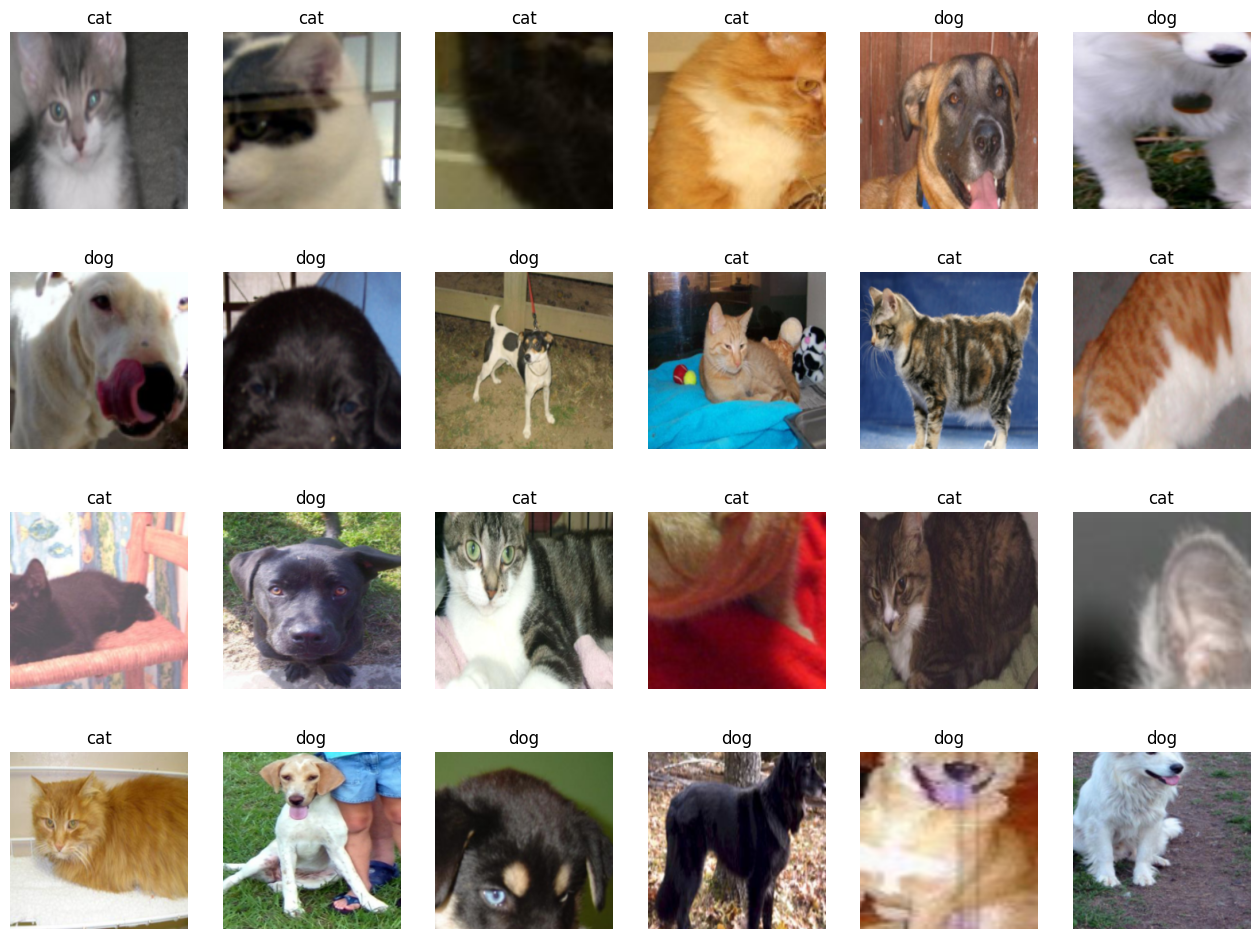

In [8]:
samples, labels = iter(train_loader).next() # iter를 사용해 반복자를 구하고 next()는 다음 출력을 구함
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    print(samples[i].shape)
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
    # np.transpose를 사용해 행과 열을 변경해 행렬의 차원을 변경(전치행렬)
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [9]:
resnet18 = models.resnet18(pretrained=True)
# pretrained된 model 호추

In [10]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
# 위 함수를 이용해 backpropagation에 값 변경 x            
set_parameter_requires_grad(resnet18)

In [11]:
resnet18.fc = nn.Linear(512, 2)
# pretrained된 model에 완전연결층 추가(class 2개)

In [12]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)
# 결과를 보면 fc.weight와 fc.bias만 return된다

fc.weight tensor([[-0.0250, -0.0163, -0.0392,  ...,  0.0188, -0.0078,  0.0188],
        [ 0.0369, -0.0262, -0.0118,  ..., -0.0407, -0.0129, -0.0134]])
fc.bias tensor([-0.0376, -0.0180])


In [13]:
model = models.resnet18(pretrained = True)
# 모델 생성

for param in model.parameters():
    param.requires_grad = False
# train x

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():
    param.requires_grad = True
# 모델의 fc만 train

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()    
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs): # 13번 반복
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            # 출력 결과와 레이블의 오차를 계산한 결과를 누적해 저장
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)        
        torch.save(model.state_dict(), os.path.join('./data/catanddog/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))    
    return acc_history, loss_history

In [15]:
params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
            
optimizer = optim.Adam(params_to_update)
# 학습 결과 optimizer에 전달

	 fc.weight
	 fc.bias


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.5420 Acc: 0.7506

Epoch 1/12
----------
Loss: 0.3865 Acc: 0.8338

Epoch 2/12
----------
Loss: 0.3024 Acc: 0.8753

Epoch 3/12
----------
Loss: 0.2726 Acc: 0.9091

Epoch 4/12
----------
Loss: 0.2534 Acc: 0.9195

Epoch 5/12
----------
Loss: 0.2825 Acc: 0.8831

Epoch 6/12
----------
Loss: 0.2167 Acc: 0.9221

Epoch 7/12
----------
Loss: 0.2389 Acc: 0.9065

Epoch 8/12
----------
Loss: 0.1874 Acc: 0.9325

Epoch 9/12
----------
Loss: 0.2228 Acc: 0.9143

Epoch 10/12
----------
Loss: 0.2781 Acc: 0.8701

Epoch 11/12
----------
Loss: 0.3092 Acc: 0.8649

Epoch 12/12
----------
Loss: 0.3099 Acc: 0.8597

Training complete in 1m 8s
Best Acc: 0.932468


In [17]:
# test dataset 생성
test_path = './data/catanddog/test'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


In [18]:
def eval_model(model, dataloaders, device):
    since = time.time()    
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('./data/catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models) # 저장된 pth 파일들 출력
    
    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders: # test 반복
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad(): # 학습 x
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)           
            preds[preds >= 0.5] = 1 # predict가 0.5보다 크면 1
            preds[preds < 0.5] = 0 # 작으면 0
            running_corrects += preds.eq(labels.to(device)).int().sum()
            
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    return acc_history

In [19]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['./data/catanddog\\00.pth', './data/catanddog\\01.pth', './data/catanddog\\02.pth', './data/catanddog\\03.pth', './data/catanddog\\04.pth', './data/catanddog\\05.pth', './data/catanddog\\06.pth', './data/catanddog\\07.pth', './data/catanddog\\08.pth', './data/catanddog\\09.pth', './data/catanddog\\10.pth', './data/catanddog\\11.pth', './data/catanddog\\12.pth']
Loading model ./data/catanddog\00.pth
Acc: 0.9082

Loading model ./data/catanddog\01.pth
Acc: 0.9286

Loading model ./data/catanddog\02.pth
Acc: 0.9694

Loading model ./data/catanddog\03.pth
Acc: 0.9490

Loading model ./data/catanddog\04.pth
Acc: 0.9490

Loading model ./data/catanddog\05.pth
Acc: 0.9388

Loading model ./data/catanddog\06.pth
Acc: 0.9694

Loading model ./data/catanddog\07.pth
Acc: 0.9184

Loading model ./data/catanddog\08.pth
Acc: 0.9694

Loading model ./data/catanddog\09.pth
Acc: 0.9592

Loading model ./data/catanddog\10.pth
Acc: 0.9184

Loading model ./data/catanddog\11.pth
Acc: 0.9592

Loading mod

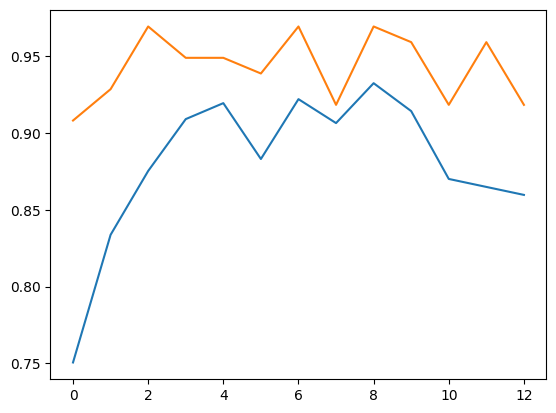

In [20]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

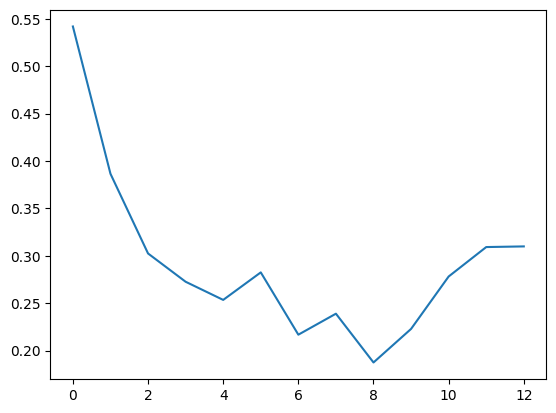

In [21]:
plt.plot(train_loss_hist)
plt.show()

In [22]:
# 예측 결과를 이미지로 표현하기 위한 전처리 함수
def im_convert(tensor):  
    image=tensor.clone().detach().numpy()  # tensor.clone은 tensor를 복사하는 함수
    image=image.transpose(1,2,0)  
    image=image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))  
    image=image.clip(0,1) # clip은 범위를 벗어날 때 input을 특정 범위로 제한시키는 함수
    return image  

|구분|메모리|계산 그래프 상주 유무|
-----|------|---------------------|
|tensor.clone()|새롭게 할당|계산 그래프에 계속 상주|
|tensor.detach()|공유해서 사용|계산 그래프에 상주하지 않음|
|tensor.clone().detach()|새롭게 할당|계산 그래프에 상주하지 않음|


In [24]:
import numpy as np
exam = np.array([-1.8, -1.2, -0.7, 0.0, 0.8, 1.4, 1.9])
print(exam)
print(np.clip(exam, -0.5, 0.5))

[-1.8 -1.2 -0.7  0.   0.8  1.4  1.9]
[-0.5 -0.5 -0.5  0.   0.5  0.5  0.5]


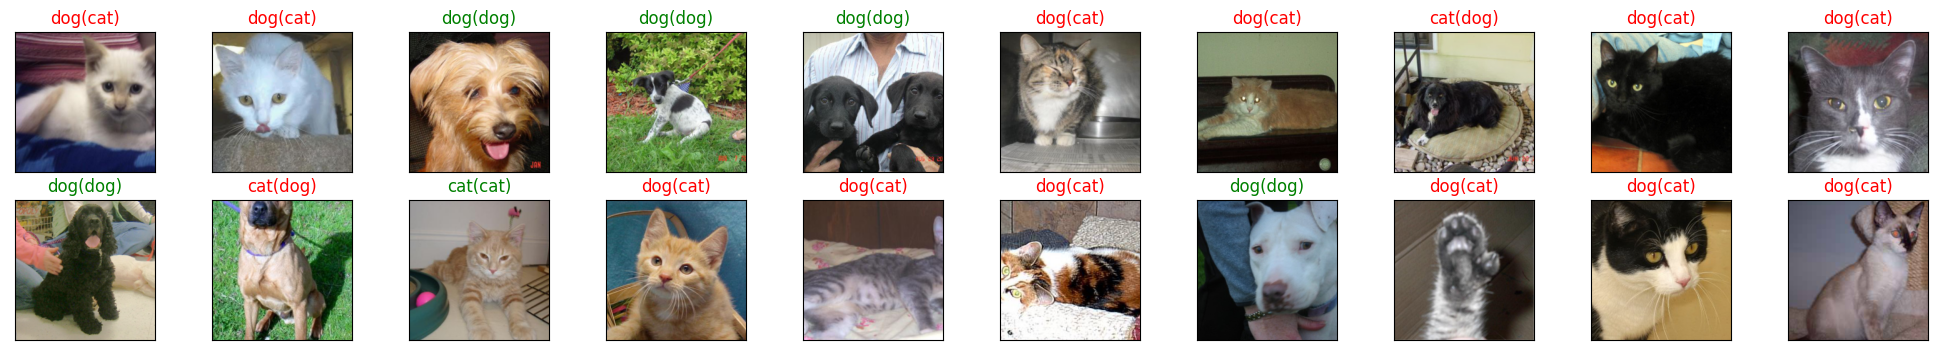

<Figure size 640x480 with 0 Axes>

In [32]:
classes = {0:'cat', 1:'dog'}

dataiter=iter(test_loader) # test dataset 불러오기
images,labels=dataiter.next() # test image의 img와 label 가져오기
output=model(images) 
_,preds=torch.max(output,1) 

fig=plt.figure(figsize=(25,4))  
for idx in np.arange(20):  
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])  
    plt.imshow(im_convert(images[idx]))  
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color=("green" if preds[idx]==labels[idx] else "red"))  
plt.show()  
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)
# 에측결과와 data의 label 순서로 title 작성
# 결과가 그닥 좋지 않은 것을 볼 수 있고 이를 해결하기 위해 train dataset을 늘리고 epoch을 늘리면 된다.

#### 5.3.2 미세 조정(fine-tuning) 기법
* 특성 추출 기법에서 더 나아가 pretrain된 model과 합성곱층, 데이터 분류기의 가중치를 update해 train 하는 방식
* 특성 추출은 목표 특성을 잘 추출했다는 전제하에 좋은 성능을 낼 수 있다.
* pretrain된 model을 목적에 맞게 재학습시키거나 학습된 가중치의 일부를 재학습시키는 것
* 데이터셋이 크고 pretrain된 모델과 유사성이 작은 경우
    * 모델 전체를 재학습. 데이터셋 크기가 크기 때문에 재학습이 good
* 데이터셋이 크고 pretrain된 모델과 유사성이 큰 경우
    * 합성곱층의 뒷부분과 데이터 분류기를 학습. 데이터셋이 유사하기 때문에 전체를 학습시키는 것보다 합성곱층의 뒷부분과 데이터 분류기만 새로 학스바는 것이 good
* 데이터셋이 작고 pretrain된 모델과 유사성이 작은 경우
    * 합성곱층의 빌부분과 데이터 분류기를 학습. 데이터가 적기 때문에 일부 계층에 미세 조정 기법을 적용해도 효과가 없을 수 있다. 따라서 합성곱층 중 어디까지 새로 학습시켜야 할지 적당히 설정
* 데이터셋이 작고 pretrain된 모델과 유사성이 큰 경우
    * 데이터 분류기만 학습. 데이터가 적기 때문에 많은 계층에 미세 조정 기법을 적용하면 overfitting 발생 가능. 최종 데이터 분류기인 fully connected layer에 대해서만 미세 조정 기법 적용하는 것이 good

## 5.4 설명 가능한 CNN(explainable CNN)
* 딥러닝 처리 결과를 사람이 이해할 수 있는 방식으로 제시하는 기술
* CNN은 블랙박스와 같아 내부에서 어떻게 동작하는지 설명하기 어렵다.
* CNN을 구성하는 각 중간 계층부터 최종 분류까지 input image의 feature가 어떻게 추출되고 학습하는지를 시각적으로 설명해야 신뢰가 올라감
* filter에 대한 시각화, CNN의 시각화가 존재

#### 5.4.1 특성 맵 시각화
* 특성 맵(feature map)은 input image 또는 다른 feature map처럼 filter를 input에 적용한 결과
* 특정 input image에 대한 feature map을 시각화한다는 의미는 feature map에서 input feature를 감지하는 방법을 이해할 수 있도록 돕는 것

In [35]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [56]:
# 13개의 합성곱층과 두 개의 fully connected layer로 구성된 network 생성
class XAI(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(XAI, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(128, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 512, bias=False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512)
        x = self.classifier(x)
        return F.log_softmax(x, -1) # log_softmax는 softmax에 log 값을 취한 연산
        # 이 함수를 통해 gradient descent 문제를 어느정도 해결 가능

In [57]:
model=XAI()
model.to(device)
model.eval()

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True

In [58]:
# layer의 feature map을 확인하기 위한 class
# Pytorch는 각 layer에 print를 하지 않더라도 hook 기능을 사용하여 각 계층의 activate function과
# gradient를 확인 가능
class LayerActivations:
    features=[]
    def __init__(self, model, layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)
        # register_forward_hook => forward 중에 각 network module의 input 및 output을 가져옴
   
    def hook_fn(self, module, input, output):
        self.features = output.detach().numpy()
 
    def remove(self): 
        self.hook.remove()

In [59]:
import torch

x = torch.Tensor([0, 1, 2, 3]).requires_grad_()
y = torch.Tensor([4, 5, 6, 7]).requires_grad_()
w = torch.Tensor([1, 2, 3, 4]).requires_grad_()
z = x + y
o = w.matmul(z)
print(o)
o.backward()
print(x.grad, y.grad, z.grad, w.grad, o.grad)

tensor(80., grad_fn=<DotBackward>)
tensor([1., 2., 3., 4.]) tensor([1., 2., 3., 4.]) None tensor([ 4.,  6.,  8., 10.]) None


C:\Users\user\AppData\Local\Temp\ipykernel_11252\377187508.py:10: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  print(x.grad, y.grad, z.grad, w.grad, o.grad)


torch.Size([1, 3, 100, 100])


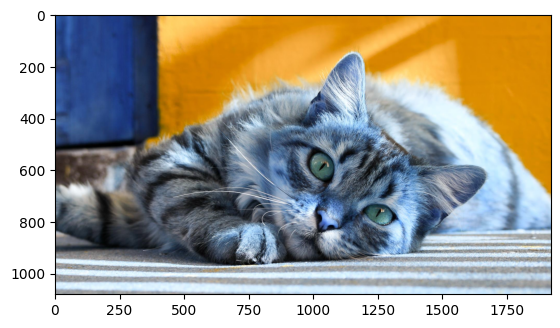

In [60]:
img=cv2.imread("./data/cat.jpg")   
plt.imshow(img)
img = cv2.resize(img, (100, 100), interpolation=cv2.INTER_LINEAR) # interpolation => 보간법
img = ToTensor()(img).unsqueeze(0)
print(img.shape)

In [64]:
result = LayerActivations(model.features, 0)

img = img.to('cpu')
model.to('cpu')
model(img)
activations = result.features

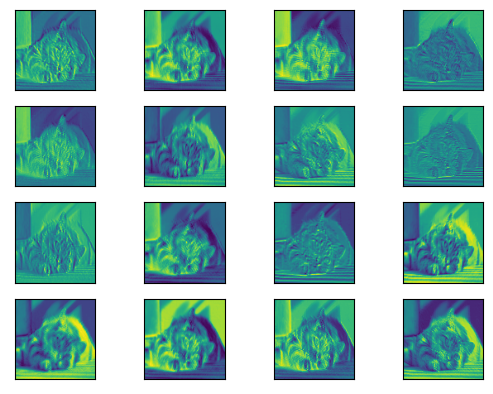

<Figure size 1200x800 with 0 Axes>

In [65]:
# input layer와 근처 Conv2d 계층 결과
# input image의 형태를 많이 유지하는 모습
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

In [66]:
result = LayerActivations(model.features, 20)

model(img)
activations = result.features

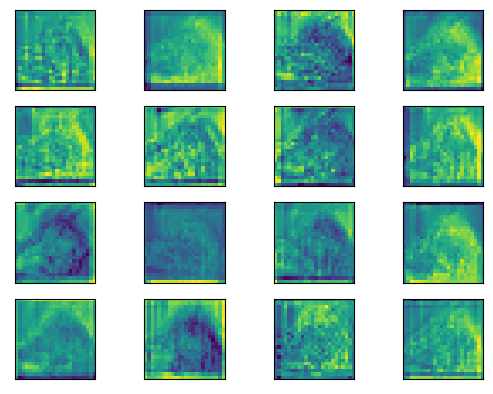

<Figure size 1200x800 with 0 Axes>

In [68]:
# 20번째 Conv2d feature map 확인
# input layer의 근처보다 input image의 모습을 잘 유지하지 못함
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

In [69]:
result = LayerActivations(model.features, 40)

model(img)
activations = result.features

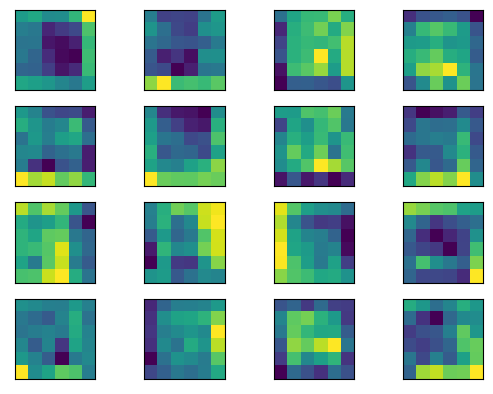

<Figure size 1200x800 with 0 Axes>

In [70]:
# 40번째 layer확인
# 더 input image의 모습이 사라짐
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

In [71]:
!jt -

Reset css and font defaults in:
C:\Users\user\.jupyter\custom &
C:\Users\user\AppData\Roaming\jupyter\nbextensions
